# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

Warning message:
“package ‘Rcpp’ was built under R version 4.0.2”
Warning message:
“replacing previous import ‘xcms::plot’ by ‘graphics::plot’ when loading ‘CAMERA’”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.0.2”
Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.0.2”
Warning message:
“package ‘DelayedArray’ was built under R version 4.0.2”
Warning message:
“package ‘matrixStats’ was built under R version 4.0.2”
Warning message:
“package ‘tidyverse’ was built under R version 4.0.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.0.2”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘readr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
Warning message:
“package ‘forcats’ was built under R version 4.0.2”
Warning message:
“package ‘gplots’ was built under R 

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [2]:
## List mzXML files
mzXMLs <- list.files(path = "PGC_neg", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Blank", 5), rep("PCYP", 5), 
                  rep("QC", 5))
sample.order <- c(6,7,5,11,14,13,12,10,4,8,1,2,3,9,15)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.42 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 15615 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Thu Oct 21 16:06:13 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Thu Oct 21 16:06:13 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 15 (15 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [15] pQC_5.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0116 F01.S0117 ... F15.S1156 (15615 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [3]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Blank", "PCYP", "QC")

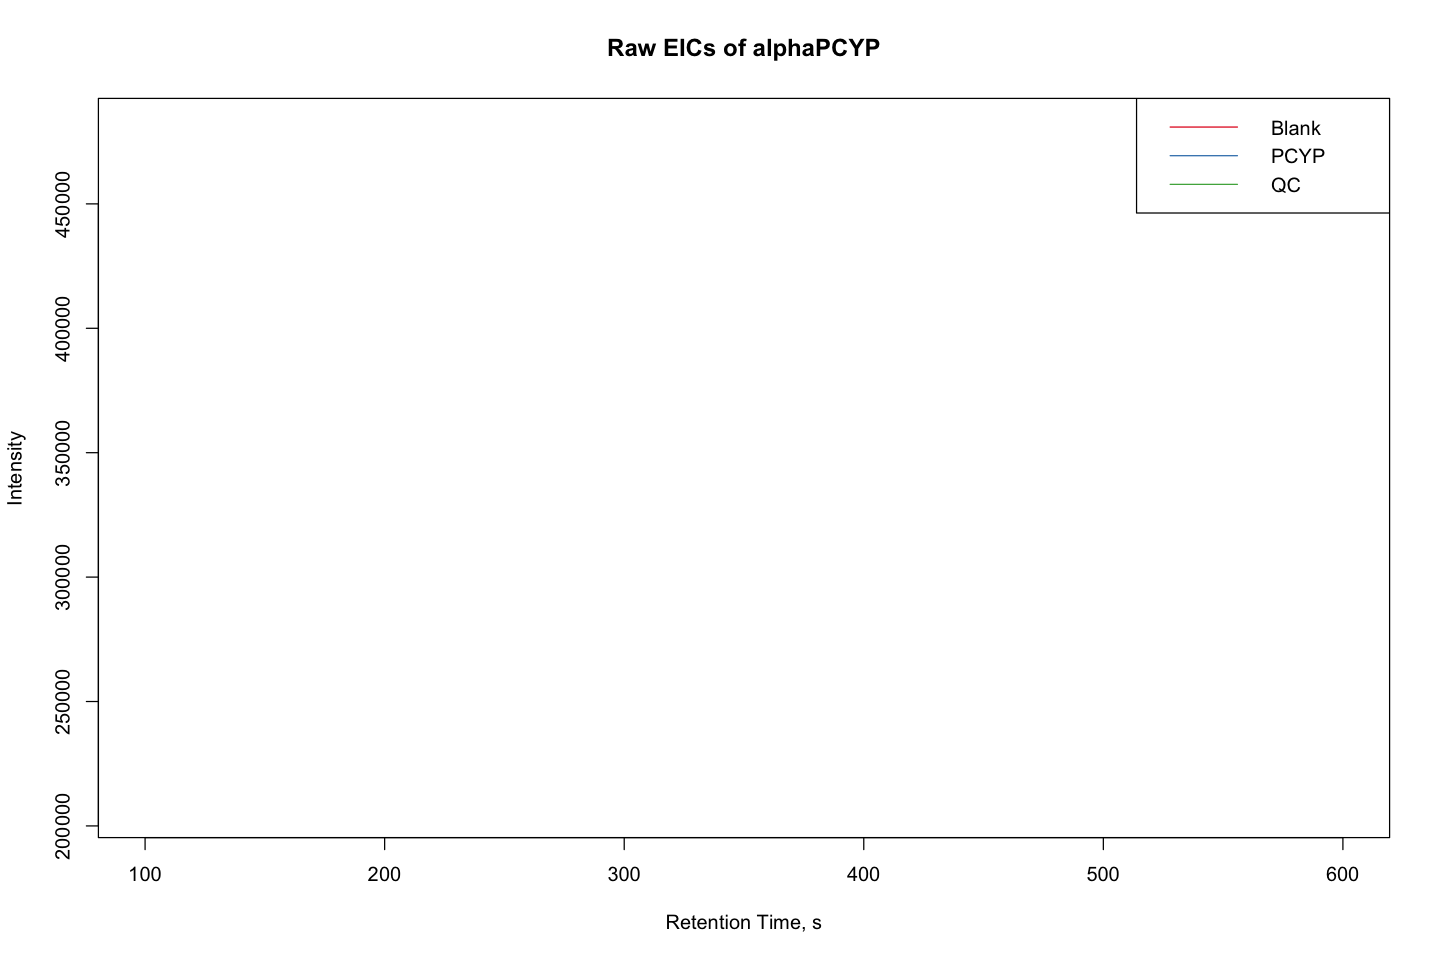

In [4]:
## Plot raw EICs of alpha-PCYP (m/z 272.2008, 25 s)
alphaPCYP.raw <- chromatogram(raw, mz = c(272.2000, 272.2015), rt = c(100, 600))

plot(alphaPCYP.raw, col = group.colours[alphaPCYP.raw$sample_group], 
     main = bquote(bold("Raw EICs of alphaPCYP")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [5]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

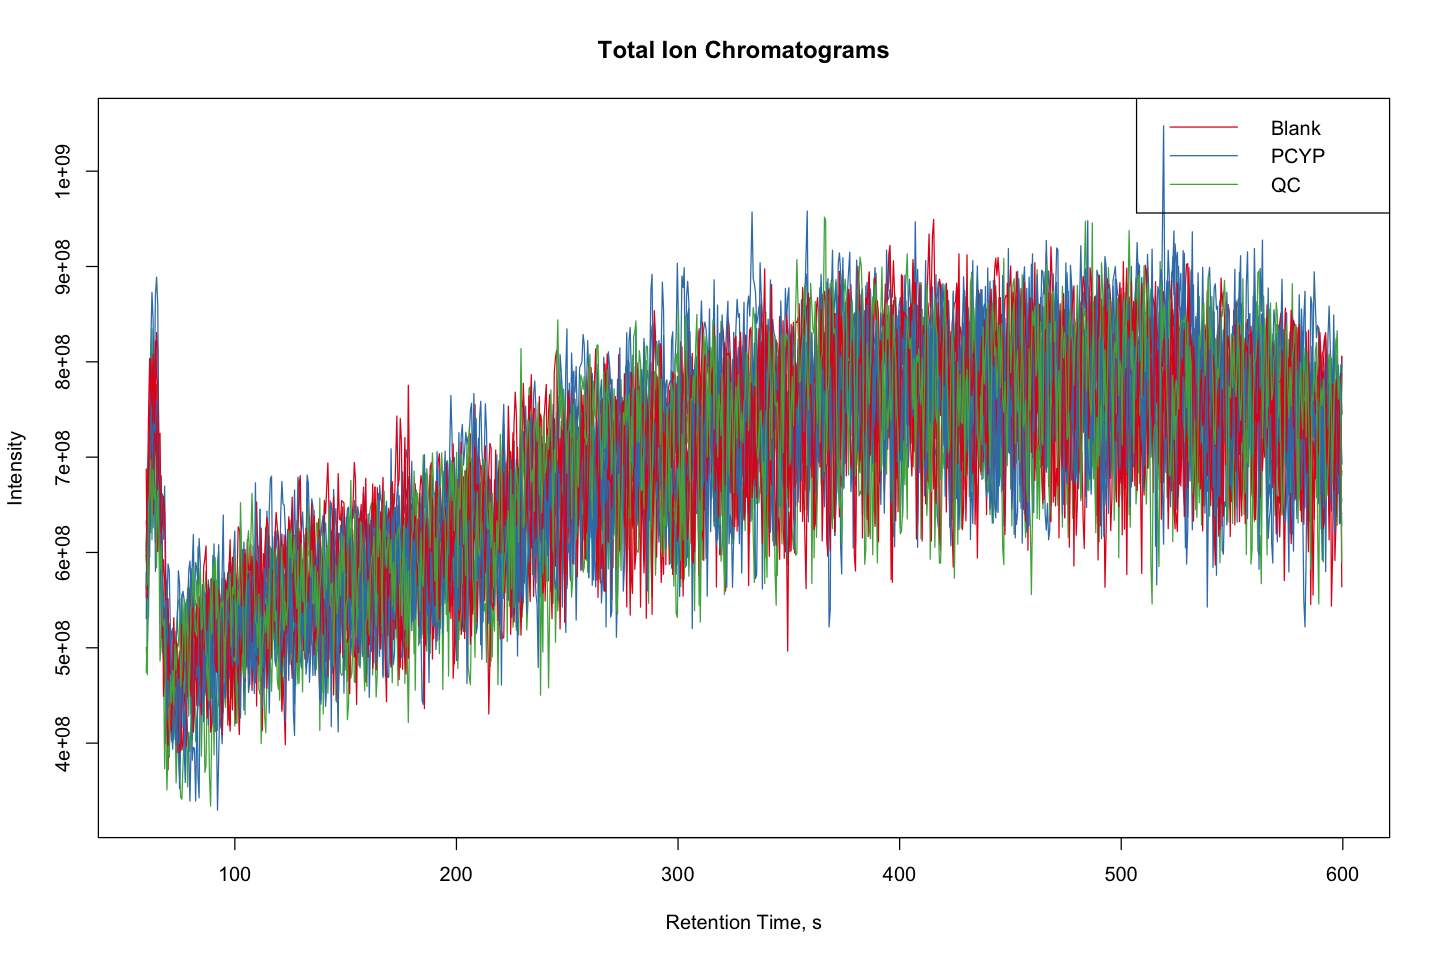

In [6]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

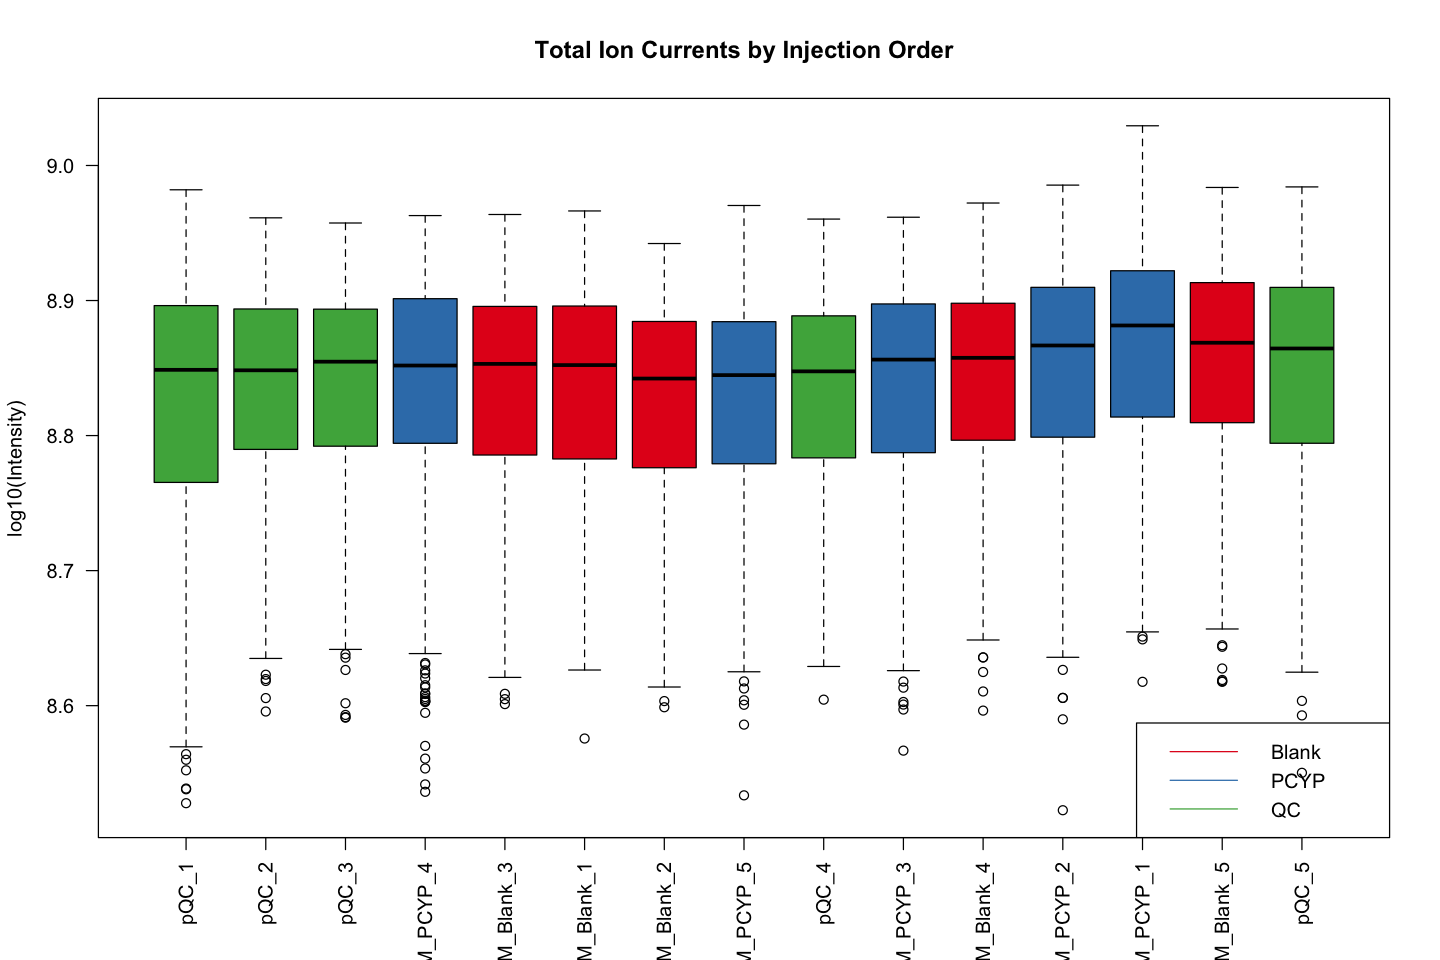

In [7]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [8]:
cwp <- CentWaveParam(peakwidth = c(8.9, 15), ppm = 1.4, snthresh = 25, 
                     mzdiff = 0.1,  prefilter = c(16, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [9]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Blank", "PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

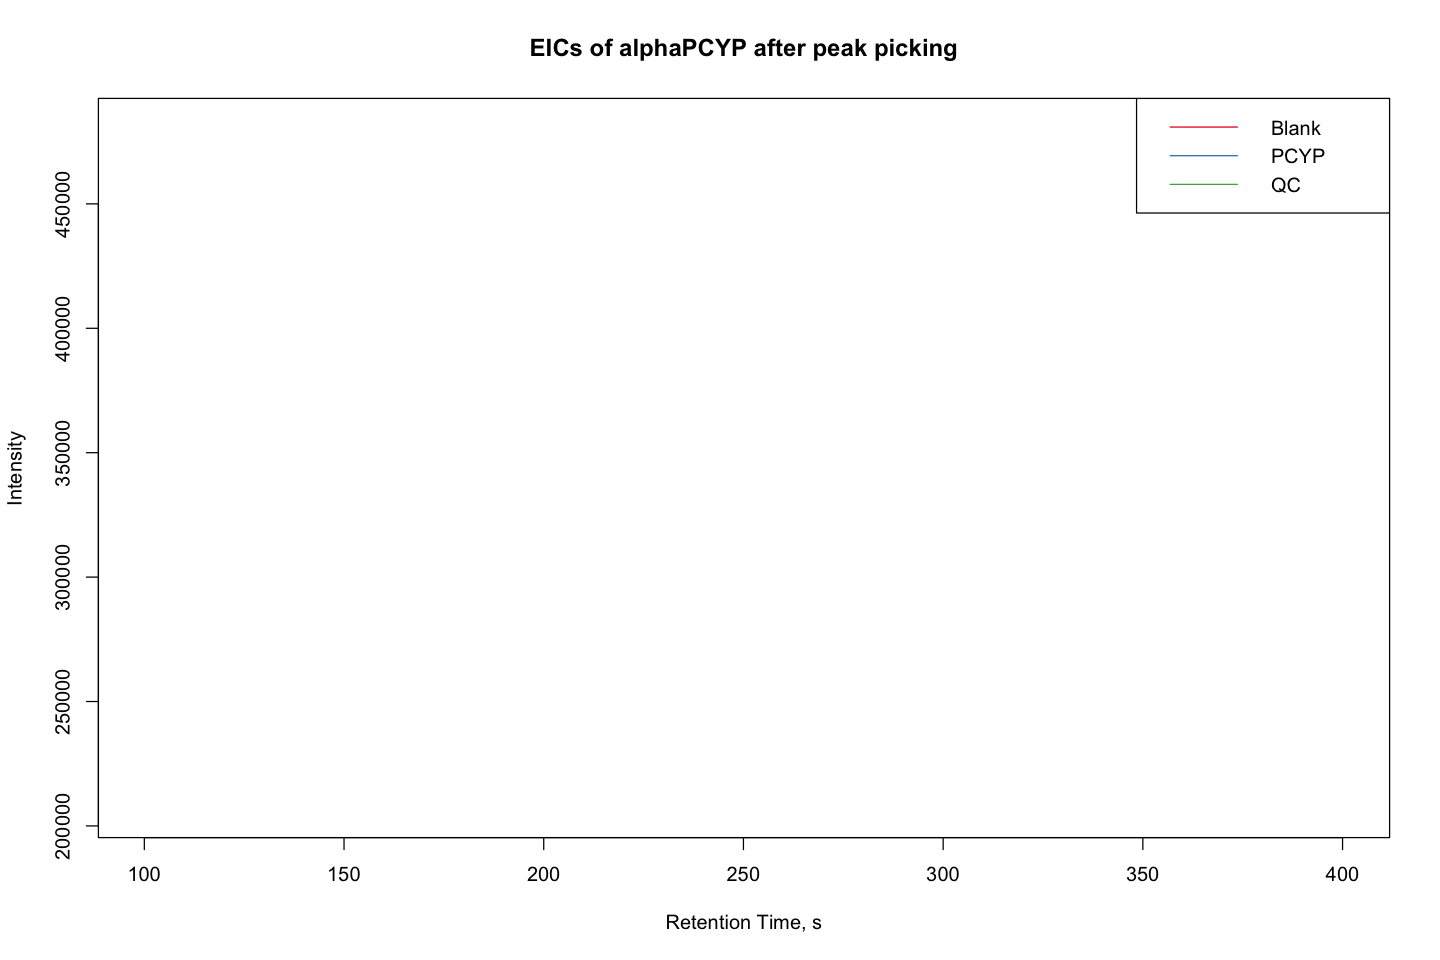

In [10]:
## Plot alpha-PCYP after peak picking (m/z 272.2008, 314 s)
alphaPCYP.picked <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 400)) 

plot(alphaPCYP.picked, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.picked)[, "sample"]],
     main = bquote(bold("EICs of alphaPCYP"*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [11]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 0.5)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

Warning message in do_adjustRtime_peakGroups(chromPeaks(object, msLevel = msLevel), :
“Span too small for 'loess' and the available number of peak groups, resetting to 0.57”
Warning message in do_adjustRtime_peakGroups(chromPeaks(object, msLevel = msLevel), :
“Fitted retention time deviation curves exceed points by more than 2x. This is dangerous and the algorithm is probably overcorrecting your data. Consider increasing the span parameter or switching to the linear smoothing method.”
Warning message:
“Adjusted retention times had to be re-adjusted for some files to ensure them being in the same order than the raw retention times. A call to 'dropAdjustedRtime' might thus fail to restore retention times of chromatographic peaks to their original values. Eventually consider to increase the value of the 'span' parameter.”


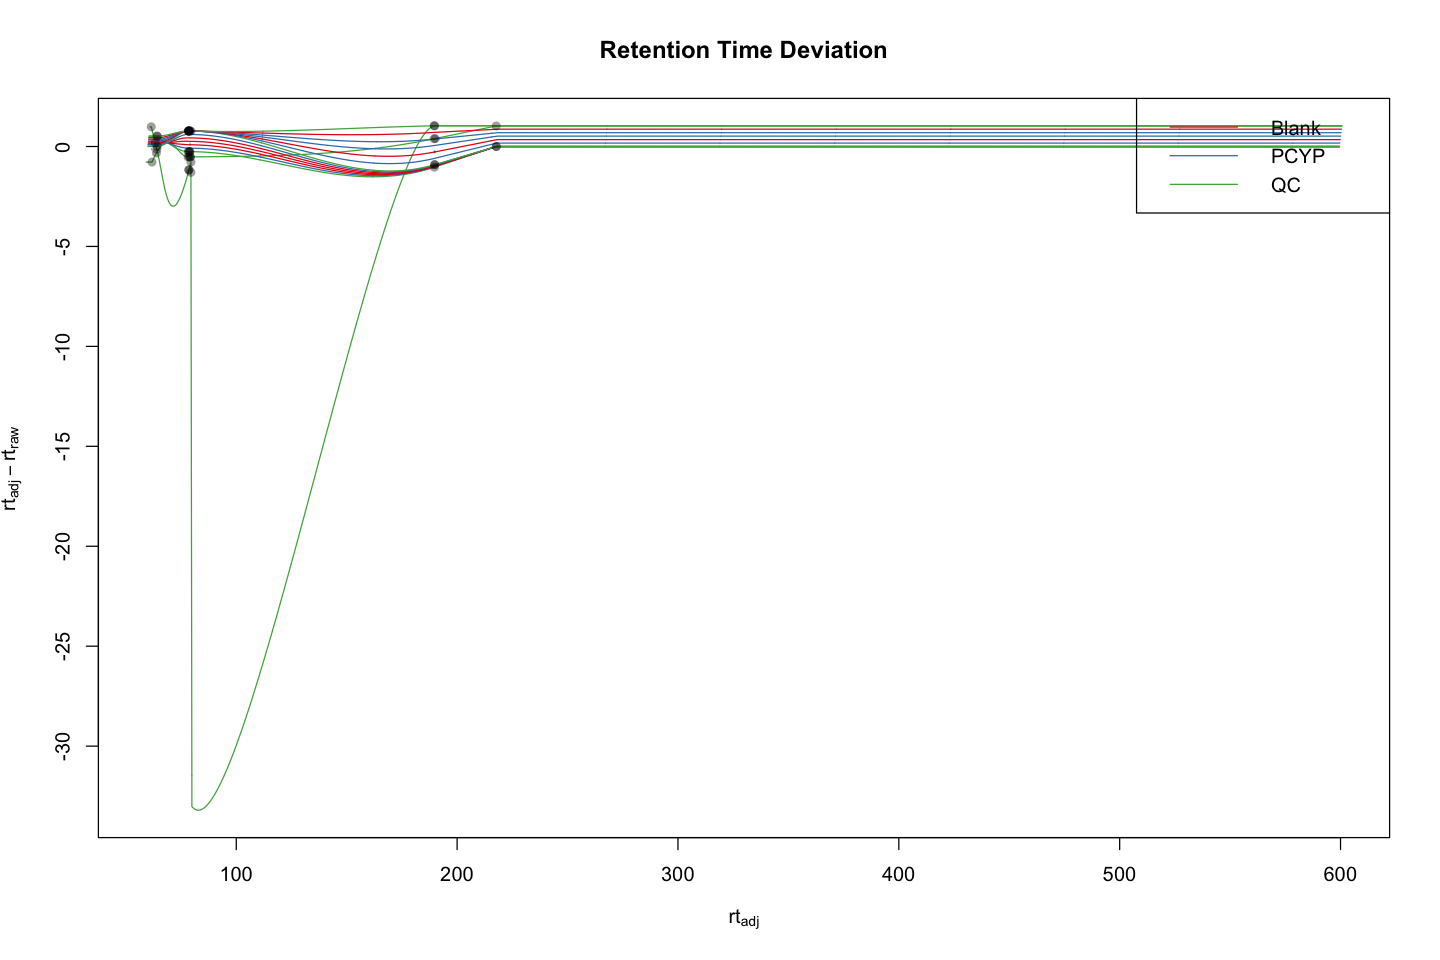

In [12]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

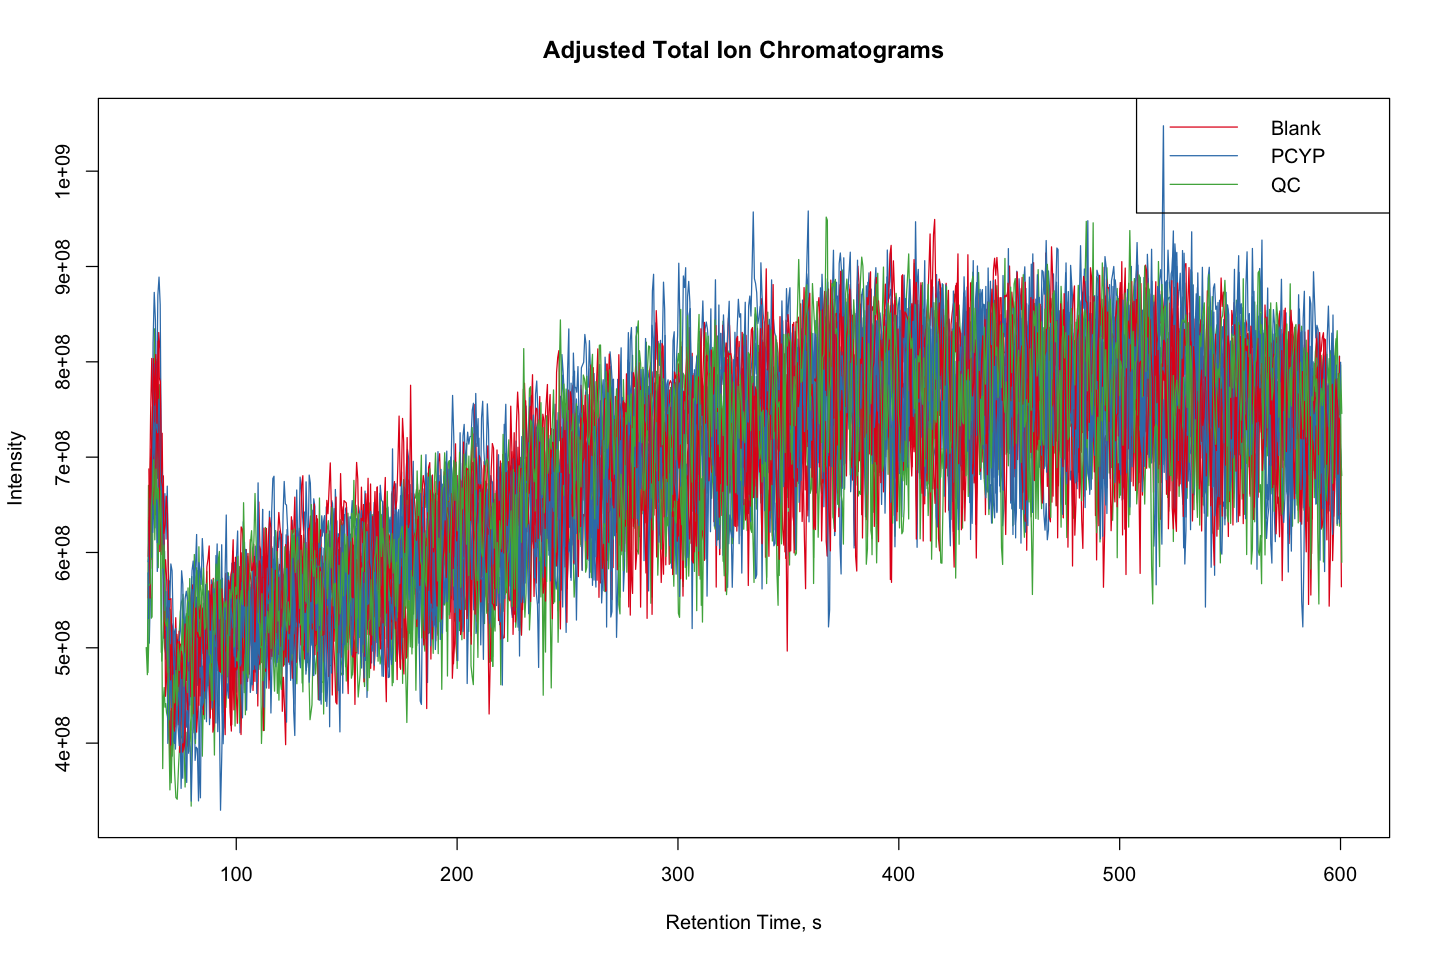

In [13]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

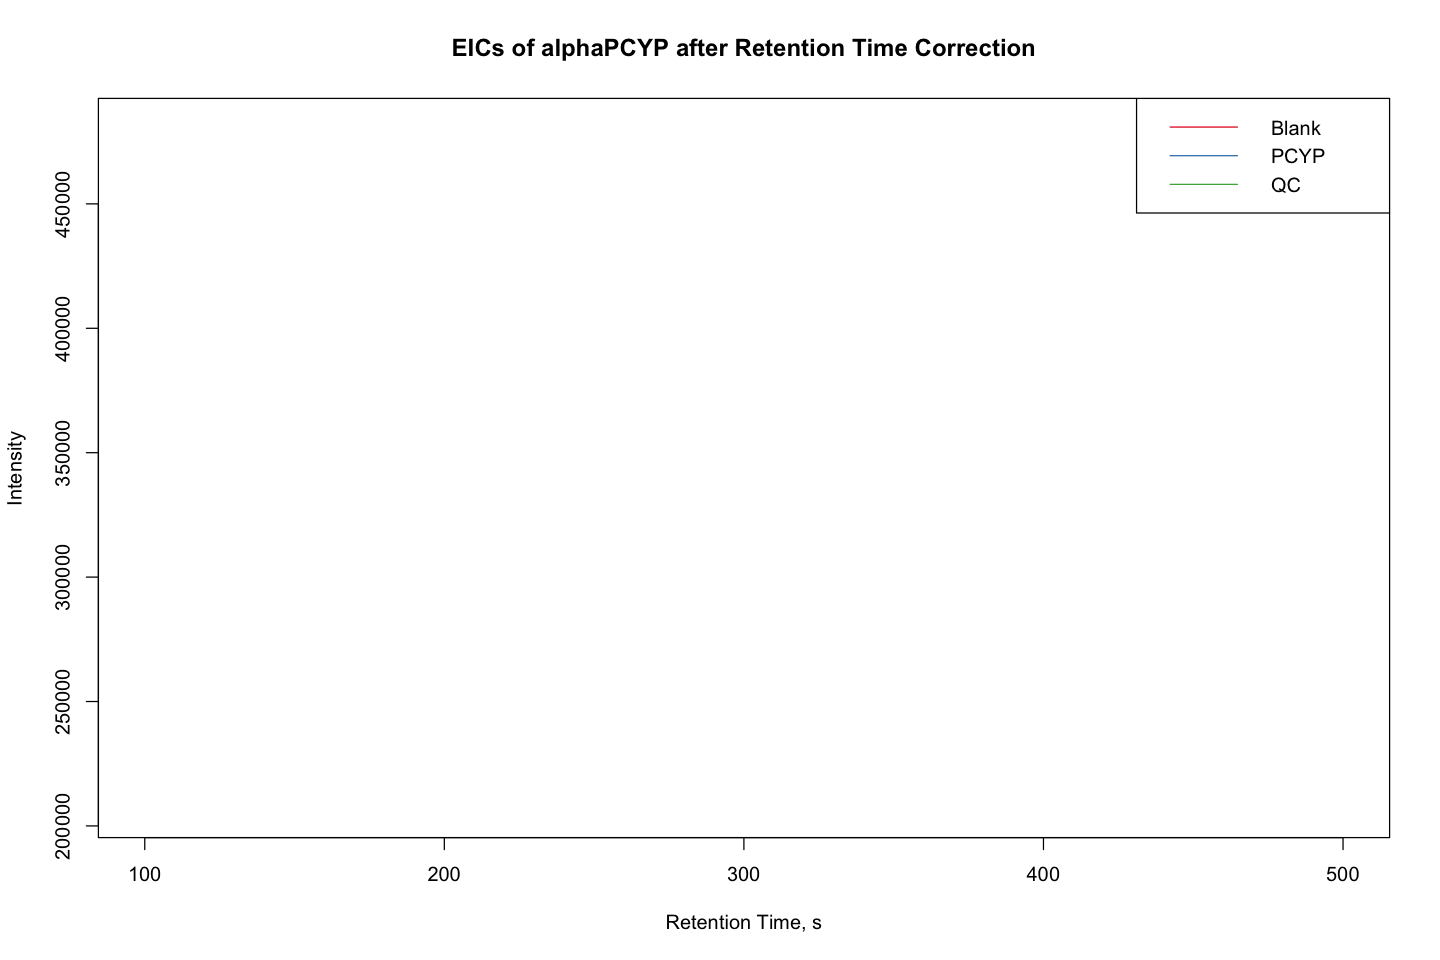

In [14]:
## Plot alpha-PCYP after retention time correction (m/z 272.2008, 314 s)
alphaPCYP.corr <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.corr, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [15]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

In [16]:
## Plot alpha-PCYP after peak grouping
alphaPCYP.grouped <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 500))

## Define the parameters for the peak density method
plotChromPeakDensity(alphaPCYP.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(alphaPCYP.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(alphaPCYP.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

ERROR: Error: No chromatographic peaks present. Please run 'findChromPeaks' first.


# Peak Filling

In [ ]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

# Postprocessing


# Annotation of Adducts and Isotopes

In [17]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [18]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
         mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
     <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT01   191.019   191.019   191.019  217.0158  215.0246  217.8825        15
FT02   192.972   192.971   192.972   64.3263   62.7778   65.0296        14
FT03   194.946   194.946   194.946   61.3253   60.7021   62.4307        12
FT04   195.810   195.810   195.811   78.9447   78.4256   79.9803        10
FT05   197.808   197.807   197.808   78.7284   78.4253   79.9806        12
FT06   199.805   199.805   199.805   78.4256   78.1661   79.4629         5
         Blank      PCYP        QC      peakidx  ms_level
     <numeric> <numeric> <numeric>       <list> <integer>
FT01         5         5         5 10,19,26,...         1
FT02         4         5         5  8,16,24,...         1
FT03         5         5         2  1,11,27,...         1
FT04         3         3         4  4,21,34,...         1
FT05         4 

In [19]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
         mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
     <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT01   191.019   191.019   191.019  217.0158  215.0246  217.8825        15
FT02   192.972   192.971   192.972   64.3263   62.7778   65.0296        14
FT03   194.946   194.946   194.946   61.3253   60.7021   62.4307        12
FT04   195.810   195.810   195.811   78.9447   78.4256   79.9803        10
FT05   197.808   197.807   197.808   78.7284   78.4253   79.9806        12
FT06   199.805   199.805   199.805   78.4256   78.1661   79.4629         5
         Blank      PCYP        QC      peakidx  ms_level       label
     <numeric> <numeric> <numeric>       <list> <integer> <character>
FT01         5         5         5 10,19,26,...         1    M191T217
FT02         4         5         5  8,16,24,...         1     M193T64
FT03         5         5         2  1,11,27,...         1     M195T61
FT04         

In [20]:
assay(results) %>% 
head()

,pQC_1.mzXML,pQC_2.mzXML,pQC_3.mzXML,HLM_PCYP_4.mzXML,HLM_Blank_3.mzXML,HLM_Blank_1.mzXML,HLM_Blank_2.mzXML,HLM_PCYP_5.mzXML,pQC_4.mzXML,HLM_PCYP_3.mzXML,HLM_Blank_4.mzXML,HLM_PCYP_2.mzXML,HLM_PCYP_1.mzXML,HLM_Blank_5.mzXML,pQC_5.mzXML
FT01,158215828,131786787,147018960,174276705,218231046,222181619,124754263,139417306,110517353,206449990,163153708,226543510,218080005,201841316,112610765
FT02,1856933368,1618988312,1621977098,1807886824,1951965629,1887074860,NA,1687641725,1434243139,1681204289,1825502461,1833248218,2104683880,2030136664,1350993147
FT03,503285825,354793723,NA,424262916,510061804,468092006,410342767,403814706,NA,371291620,440897185,431875355,545370431,507593391,NA
FT04,9585848,NA,14880935,NA,11686031,NA,16490918,NA,13799087,14348972,13096357,14133509,13174172,NA,12301186
FT05,12226638,19836207,20452251,NA,NA,16943071,20572689,20333529,19528120,19001502,15181163,NA,16834727,15575049,16854834
FT06,NA,8961534,10604986,NA,NA,NA,NA,NA,8811197,NA,NA,7883049,NA,NA,6938392


In [22]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "negative") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 5 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  40  50  100  
Found isotopes: 1 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 5 Groups... 
 % finished: 10  20  40  50  100  

Calculating graph cross linking in 5 Groups... 
 % finished: 10  20  40  50  100  
New number of ps-groups:  7 
xsAnnotate has now 7 groups, instead of 5 
Generating peak matrix for peak annotation!

Calculating possible adducts in 7 Groups... 
 % finished: 10  20  40  50  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [23]:
assays(results)

List of length 1
names(1): raw

In [24]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [25]:
assays(results)

List of length 2
names(2): raw scaled

In [26]:
results %>%
assay("scaled") %>%
head()

,pQC_1.mzXML,pQC_2.mzXML,pQC_3.mzXML,HLM_PCYP_4.mzXML,HLM_Blank_3.mzXML,HLM_Blank_1.mzXML,HLM_Blank_2.mzXML,HLM_PCYP_5.mzXML,pQC_4.mzXML,HLM_PCYP_3.mzXML,HLM_Blank_4.mzXML,HLM_PCYP_2.mzXML,HLM_PCYP_1.mzXML,HLM_Blank_5.mzXML,pQC_5.mzXML
FT01,8.199250,8.119872,8.167373,8.241239,8.338917,8.346708,8.096055,8.144317,8.043430,8.314815,8.212597,8.355152,8.338616,8.305010,8.051580
FT02,9.268796,9.209244,9.210045,9.257171,9.290472,9.275789,6.841259,9.227280,9.156623,9.225620,9.261382,9.263221,9.323187,9.307525,9.130653
FT03,8.701815,8.549976,6.841259,8.627635,8.707623,8.670331,8.613147,8.606182,6.841259,8.569715,8.644337,8.635358,8.736692,8.705516,6.841259
FT04,6.981631,6.841259,7.172630,6.841259,7.067667,6.841259,7.217245,6.841259,7.139850,7.156821,7.117151,7.150250,7.119723,6.841259,7.089947
FT05,7.087307,7.297459,7.310741,6.841259,6.841259,7.228992,7.313291,7.308213,7.290660,7.278788,7.181305,6.841259,7.226206,7.192429,7.226724
FT06,6.841259,6.952382,7.025510,6.841259,6.841259,6.841259,6.841259,6.841259,6.945035,6.841259,6.841259,6.896694,6.841259,6.841259,6.841259


# Normalisation

In [28]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [80]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 210.1291, rt = 148, 5, 10)

In [81]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = trpd5)

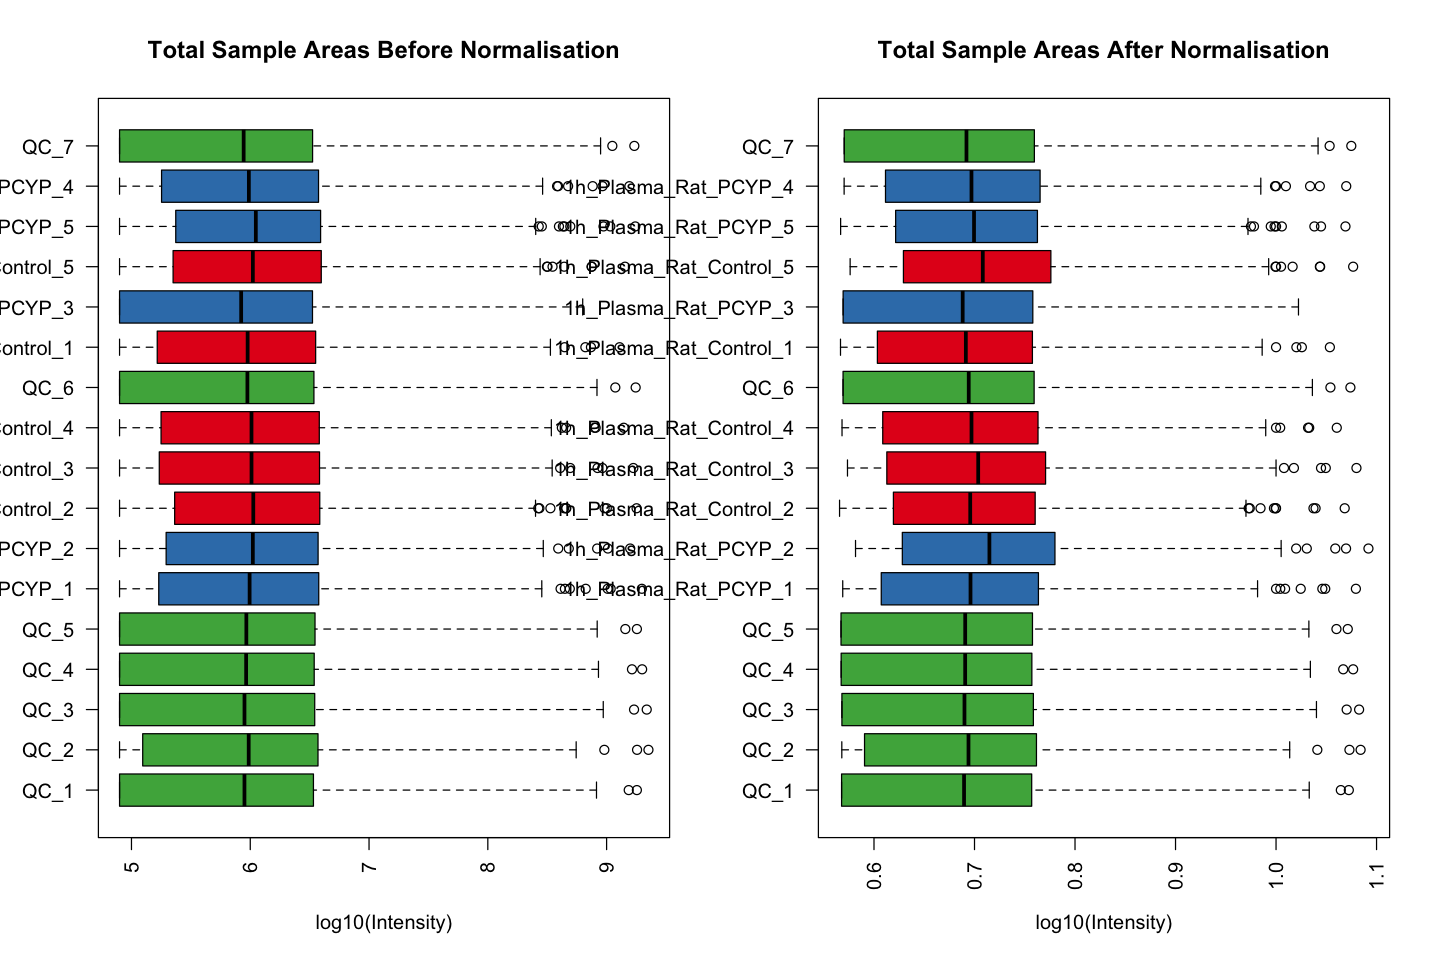

In [82]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [27]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [28]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [29]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

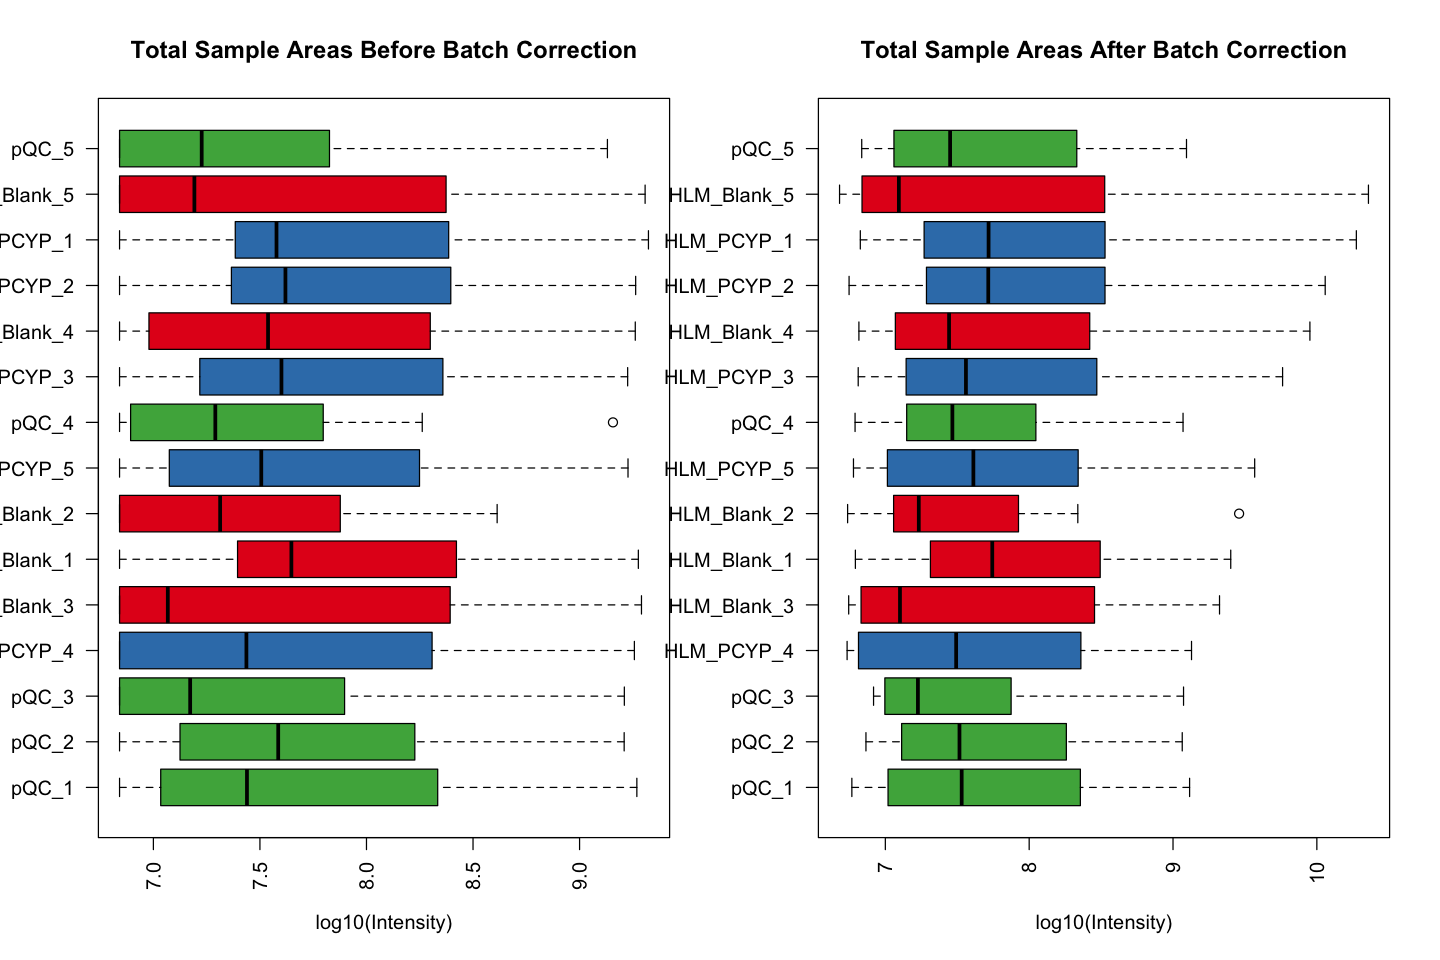

In [30]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [31]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

ERROR: Error in assay(results, "scaled")[51, ]: Indizierung außerhalb der Grenzen


In [32]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'plot': Objekt des Typs 'closure' ist nicht indizierbar
